# Table of Contents
 <p>

# MOT Temperature Calculation

- Mark Brown  
April 3rd, 2017

- Revised by Mark Brown  
June 6th, 2018

## Imports and Matplotlib defaults

In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import curve_fit as fit
from matplotlib.pyplot import *
import math as m
import sys
import MarksConstants as mc
### set matplotlib plot defaults :D
%matplotlib inline
# Style controls many default colors in matplotlib plots.
# Change the following if you don't like dark backgrounds. Many other options.
style.use(['dark_background'])
mpl.rcParams['axes.facecolor'] = '#0a0a0a'
# the default cycling of colors in this mode isn't very good.
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['r','c','g','#FFFFFF','y','m','b'])
mpl.rcParams['figure.figsize'] = (18.0, 8.0)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['grid.alpha'] = 0.3
# jet is awful.
mpl.rcParams['image.cmap'] = 'magma'
# to see all available options, decomment this line.
#print(mpl.rcParams)

# Theory

This is based on the following paper:


**Time-of-flight measurement of the temperature of cold atoms for short trap-probe beam distances**  
by... Tomasz M Brzozowski, Maria Maczynska, Michal Zawada, Jerzy Zachorowski and Wojciech Gawlik

We are interested in finding the temperature of the cloud of atoms. Classically, the velocity of the atoms follows the maxwell-boltzmann distribution:

$$
P(v_i) = \sqrt{\frac{m}{2\pi k_B T}} \exp{\Big\{-\frac{mv^2}{2 k_B T}\Big\}}
$$

This is a gaussian distribution with standard deviation
$$
\sigma_v^2 = \frac{k_B T}{m},  \qquad T = \frac{m\sigma_v^2}{k_B}
$$

I'll parameterize this work in terms of $\sigma_v$ for convenience.

For Rubidium 87,

In [56]:
mc.Rb87_M / mc.k_B

$$T\approx 0.010453\sigma_v^2$$

Keep in mind that this is 1-dimensional.

The initial distribution of atoms is given by a function $P(x_0)=P(x,t=0)$. What is $P(x,t)$?

Consider a population of atoms located at position $x_0$. If the atoms have a velocity $v_x$, then after at time $t$ the atoms are at $x = x_0 + v_x t$. In terms of $x$ then, $v_x = \frac{x-x_0}{t}$. If the velocities follow a probability distribution $P_v(v_x)$, then the probability of finding the population at $x$ is, given the initial position, the probability of having a velocity that puts the atoms there, or $P_1(x)$=$P_v(\frac{x-x_0}{t})$ (1 for one $x_0$).

If I now generalize the atoms as having some initial distribution x, then in principle the atoms could reach the position $x$ from any loction in the initial distribution. So I need to multiply $P_1(x)$ by the probability of finding and atom at a given $x_0$ and then integrate over all possible $x_0$:

$$
P(x,t) = \int P\{x_0\}P_v\big\{\frac{x-x_0}{t}\big\}dx_0
$$

In principle we could use this with the exact initial distribution which we can easily measure, but practically speaking we can model the spatial distribution as a gaussian. As discussed above, the velocity distribution $P_v$ is also gaussian.

$$
P(x,t) \propto \frac{1}{2\pi\sigma_x \sigma_v}\int \exp\big\{-\frac{x_0^2}{2\sigma_x^2}\big\}\exp\big\{-\frac{(x-x_0)^2}{2t^2\sigma_v^2}\big\}dx_0
$$

(I should have to renormalize after plugging in the time-dependent term into the velocity distribution but I don't care about the overall amplitude in the end).

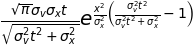

In [55]:
import sympy as sp
sp.init_printing(use_latex=True)
x_0 = sp.Symbol('x_0', real=True)
x = sp.Symbol('x', real=True)
t = sp.Symbol('t', positive=True)
sigma_v = sp.Symbol('sigma_v', positive=True)
sigma_x = sp.Symbol('sigma_x', positive=True)
expr = sp.exp(-x_0**2 / (sigma_x**2)) * sp.exp(-(x-x_0)**2/(t**2*sigma_v**2))
res = sp.simplify(sp.Integral(expr, (x_0, -sp.oo,sp.oo)).doit())
display(res)

Sympy seems to have trouble simplifying that exponent quite fully, it simplifies to
$$
\sim \exp\big\{-\frac{x^2}{\sigma_v^2t^2+\sigma_x^2}\big\}
$$

I.e. a gaussian distribution with 
$$\sigma_{x\{t\}} = \sqrt{\sigma_v^2t^2+\sigma_x^2}$$


We are close now. If we assume that we measure the real standard deviation of the atom cloud directly, we would be done, but in principle the width of the gaussian that we measure is effected by the finite waist of the imaging laser as well.

That is, we measure
$$M(x) = I(x) * A(x)$$

where $A(x)$ is the atom distribution, $I(x)$ is the intensity distribution, and $M(x)$ is what we directly measure. Since both are gaussians, this simply results in another gaussian with a sigma that is the harmonic wasit of these two:

$$
\sigma_m = \frac{\sigma_I  \sigma_{x\{t\}}}{\sqrt{\sigma_I^2 + \sigma_{x\{t\}}^2}}
$$

In [2]:
from fitters import FullBalisticMotExpansion, LargeBeamMotExpansion

### todo: demo...